In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from fastcore.xtras import load_pickle

import matplotx
import numpy as np
import pandas as pd


from gptchem.plotsettings import * 

%matplotlib inline

In [3]:
all_res = glob("out/**/*.pkl")

In [4]:
compiled_res = []
compiled_gpr = []

for res in all_res:
    loaded = load_pickle(res)

    num_points = loaded["num_train_points"]

    metrics = {
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["mean_absolute_error"],
        "max_error": loaded["max_error"],
        "mse": loaded["mean_squared_error"],
    }

    compiled_res.append(metrics)

    gpr_metrics = {
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["baseline"]["mean_absolute_error"],
        "max_error": loaded["baseline"]["max_error"],
        "mse": loaded["baseline"]["mean_squared_error"],
    }

    compiled_gpr.append(gpr_metrics)

In [5]:
compiled_res = pd.DataFrame(compiled_res)
compiled_gpr = pd.DataFrame(compiled_gpr)

In [6]:
compiled_grouped_res = compiled_res.groupby(["num_train_points"]).agg(["mean", "std", "count"])

In [7]:
compiled_gpr_grouped = compiled_gpr.groupby(["num_train_points"]).agg(["mean", "std"])

In [8]:
compiled_grouped_res

mae                 max_error                  \
                      mean       std count      mean       std count   
num_train_points                                                       
10                2.640584  0.117651     5  8.502000  0.812447     5   
20                2.731860  0.211667     4  9.110000  0.688815     4   
50                2.469320  0.090165     5  8.224000  0.581231     5   
100               1.899230  0.351440     4  6.120000  1.138537     4   
200               0.805530  0.059767     4  4.075000  0.436692     4   
500               0.639133  0.022174     3  2.943333  0.412836     3   

                        mse                  
                       mean       std count  
num_train_points                             
10                10.331680  0.920768     5  
20                11.383185  1.594730     4  
50                 9.098974  0.562224     5  
100                5.652357  1.889109     4  
200                1.114815  0.170391     4  
500                0.656776  0.025485     3

/Users/kevinmaikjablonka/git/kjappelbaum/plotutils/plotutils.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_min - pad * (x_max - x_min), x_max + pad * (x_max - x_min))


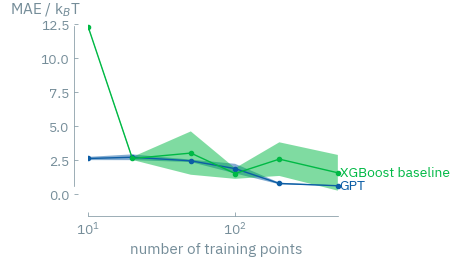

In [14]:
fig, ax = plt.subplots(1, 1)

ax.plot(
    compiled_grouped_res.loc[:].index,
    compiled_grouped_res.loc[:]["mae"]["mean"],
    label="GPT",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc[:].index,
    compiled_grouped_res.loc[:]["mae"]["mean"] - compiled_grouped_res.loc[:]["mae"]["std"],
    compiled_grouped_res.loc[:]["mae"]["mean"] + compiled_grouped_res.loc[:]["mae"]["std"],
    alpha=0.5,
)

ax.plot(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped["mae"]["mean"],
    label="XGBoost baseline",
    marker="o",
)

ax.fill_between(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped.loc[:]["mae"]["mean"] - compiled_gpr_grouped.loc[:]["mae"]["std"],
    compiled_gpr_grouped.loc[:]["mae"]["mean"] + compiled_gpr_grouped.loc[:]["mae"]["std"],
    alpha=0.5,
)

matplotx.line_labels()

ax.set_xlabel("number of training points", labelpad=4)
ylabel_top(r"MAE / k$_B$T", y_pad=0.05)
ax.set_xscale("log")

range_frame(
    ax,
    compiled_gpr_grouped.loc[:].index,
    np.stack(
        [
             compiled_gpr_grouped.loc[:]["mae"]["mean"] + compiled_gpr_grouped.loc[:]["mae"]["std"],
                compiled_grouped_res.loc[:]["mae"]["mean"] - compiled_grouped_res.loc[:]["mae"]["std"]
        ]
    ).flatten()
)

fig.savefig("polymer_regression_res.pdf", bbox_inches="tight")